In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt 

from skimage import measure,morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

#Constants
INPUT_FOLDER = '/home/manish/data/kaggleCancer/sample_images/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [2]:
#Load the scans in the folder
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - sleices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [3]:
def get_pixel_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
    
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [4]:
first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixel_hu(first_patient)

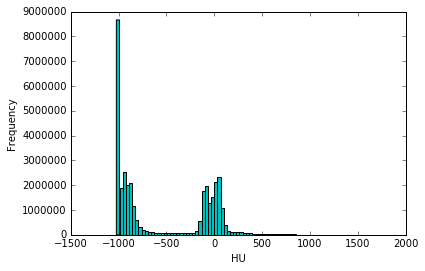

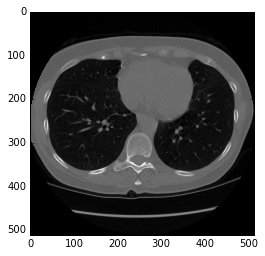

In [5]:
plt.hist(first_patient_pixels.flatten(),bins=80,color='c')
plt.xlabel("HU")
plt.ylabel("Frequency")
plt.show()
plt.imshow(first_patient_pixels[80],cmap=plt.cm.gray)
plt.show()

In [6]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [7]:
%timeit
pix_resampled, spacing = resample(first_patient_pixels,first_patient,[1,1,1])
print("Shape Before:\t",first_patient_pixels.shape)
print("Shape After:\t",pix_resampled.shape)
%timeit

Shape Before:	 (134, 512, 512)
Shape After:	 (335, 306, 306)


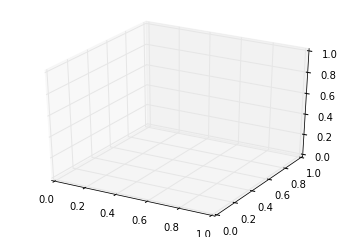

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


In [9]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

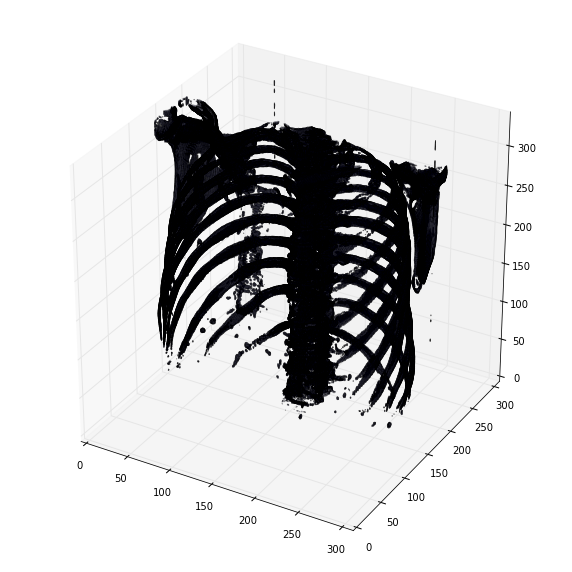

In [10]:
plot_3d(pix_resampled, 400)

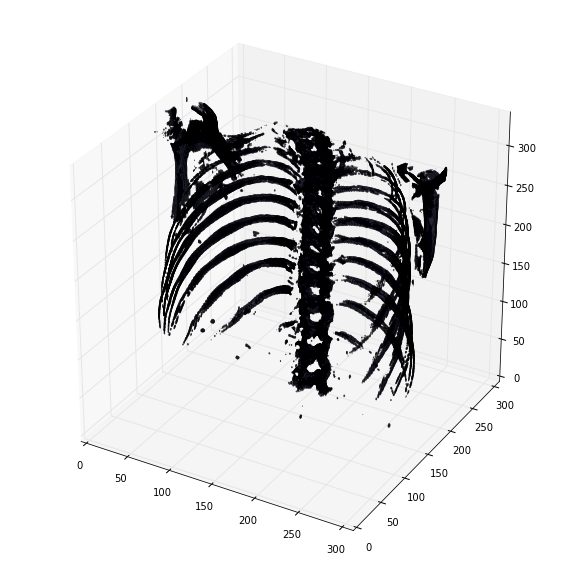

CPU times: user 51.1 s, sys: 768 ms, total: 51.8 s
Wall time: 49.8 s


In [11]:
%time plot_3d(pix_resampled, 700)

In [ ]:
%time plot_3d(pix_resampled, 0)

In [ ]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    biggest = vals[np.argmax(counts)]
    return biggest

In [ ]:
def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [ ]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

In [ ]:
plot_3d(segmented_lungs, 0)